**Gender Classification using CNN**

Libraries

We import all the libraries we need for developing a classification model for gender classification using images. Additionally, keras tuner library installed and imported as the hyperparameter optimization library since it is easy to use and model can be trained on GPU.

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout,Dense, MaxPooling3D,BatchNormalization,AveragePooling3D
from keras import layers,models
!pip install keras-tuner
import kerastuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.8 MB/s eta 0:00:00


<ipython-input-1-30597cec2df1>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
from google.colab import drive

# Mount Google Drive to save and load data/models.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# seed is set to get specific random initialization
def set_seed(seed_value=5240):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [60]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.style.use("ggplot")
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    return fig

In [4]:
# to work with path easily
os.chdir("/content/drive/My Drive/GenderClassification/")
os.getcwd()

'/content/drive/My Drive/GenderClassification'

This dataset is Kaggle Gender Classification Dataset. https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset/

In [5]:
DATADIR = 'data/'
CATEGORIES = ["female", "male"]   # Class 0=female, Class 1=male
IMG_SIZE = 50 # can be chosen different

Simple example for each class in grayscale and color.

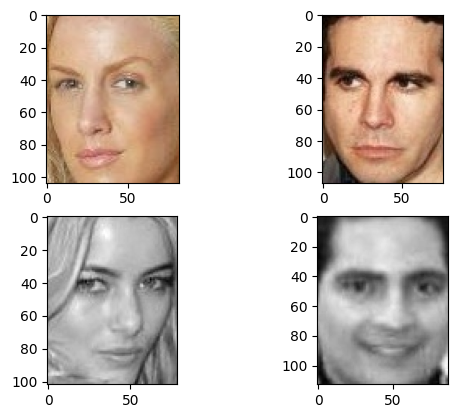

In [6]:
# show examples of color and gray images

female_img_color = cv2.imread(DATADIR +'female/112967.jpg.jpg')
male_img_color = cv2.imread(DATADIR + 'male/090634.jpg.jpg')
plt.subplot(2,2,1)
plt.imshow(female_img_color[:,:,::-1])
plt.subplot(2,2,2)
plt.imshow(male_img_color[:,:,::-1])
female_img_gray = cv2.imread(DATADIR +'female/131429.jpg.jpg',cv2.IMREAD_GRAYSCALE)
male_img_gray = cv2.imread(DATADIR + 'male/063443.jpg.jpg',cv2.IMREAD_GRAYSCALE)
plt.subplot(2,2,3)
plt.imshow(female_img_gray,cmap='gray')
plt.subplot(2,2,4)
plt.imshow(male_img_gray,cmap='gray')
plt.show()

In [7]:
# number of training and testing samples
female_data = len(os.listdir(DATADIR + CATEGORIES[0]))
male_data = len(os.listdir(DATADIR + CATEGORIES[1]))

total = female_data + male_data

print("There are",total," samples.")
print("Female dataset size is",female_data,".")
print("Male dataset size is", male_data, ".")

There are 59898  samples.
Female dataset size is 30024 .
Male dataset size is 29874 .


In general, we store images as formats .jpg, .png, etc. However, to use images in models we need to convert them into arrays or tensors. To do that "convert_image_to_array" function can be used. In this function, firstly, images are read and resized with the numbers which we define above with opencv library. While converting images to arrays, we store also labels. Lastly, we reshape the image arrays into 3 dimensions.

In [8]:
# ------- create X and y for training ------

def convert_image_to_array(data_dir):
    X = []
    y = []
    for category in CATEGORIES:
        path = os.path.join(data_dir,category)
        print(path)
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1).

        for img in tqdm(os.listdir(path)[:15000]):  # iterate over each image per class

              # convert to array
              img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
              # resize to given data size
              new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
              X.append(new_array)
              y.append(class_num)

    X = np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE,1) # reshape X

    return X, y

In [ ]:
X,y = convert_image_to_array(DATADIR)
np.savez(DATADIR +'array_data.npz', array1=X, array2=y)

While training the machine learning model, data is splited into train, validation and test datasets. In the function below, data is splitted into train and test with the size of 75% and %25, correspondly. In this step, validation set was not seperated since we split train into train and validation while the training the model. Also, data is normalized just dividing pixel values with 255.

In [10]:
def train_test_split_normalization(X,y):

    # Assuming you have your data X and labels y as NumPy arrays
    # X should have shape (n_samples, n_features) and y should have shape (n_samples,)

    # Split the data into training (75%),and test (25%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    # Print the sizes of the resulting sets
    print("Train set size:", X_train.shape)
    print("Test set size:", X_test.shape)



    # Normalize pixel values to be between 0 and 1
    X_train, X_test = X_train / 255.0, X_test / 255.0
    return X_train, X_test, y_train, y_test

In [11]:
set_seed()
# Load the NPZ file
data = np.load(DATADIR +'array_data.npz')

# Access the arrays using the keys specified during saving
X = data['array1']
y = data['array2']

train_X, test_X, train_y, test_y = train_test_split_normalization(X,y)

# check the shape of data
print(f"train_images - Type: {type(train_X)}, Shape {train_X.shape}")
print(f"test_images - Type: {type(test_X)}, Shape {test_X.shape}")
print(f"train_labels - Type: {type(train_y)}, Shape {train_y.shape}")
print(f"test_labels - Type: {type(test_y)}, Shape {test_y.shape}")

Train set size: (22500, 50, 50, 1)
Test set size: (7500, 50, 50, 1)
train_images - Type: <class 'numpy.ndarray'>, Shape (22500, 50, 50, 1)
test_images - Type: <class 'numpy.ndarray'>, Shape (7500, 50, 50, 1)
train_labels - Type: <class 'numpy.ndarray'>, Shape (22500,)
test_labels - Type: <class 'numpy.ndarray'>, Shape (7500,)


The arrays are converted into tensors to use GPU in keras tuner.

In [12]:
X_trainT = tf.convert_to_tensor(train_X, dtype=tf.float32)
X_testT = tf.convert_to_tensor(test_X, dtype=tf.float32)

Y_trainT = tf.convert_to_tensor(train_y, dtype=tf.int64)
Y_testT = tf.convert_to_tensor(test_y, dtype=tf.int64)

**Hyperparameter Tuning**

As I mentioned above, keras tuner library is used to find the optimum model where the hyperparameters' range is experimented. To use the keras tuner;


1.   Set the hyperparameter space range.
2.   Set the model's skeleton.
3.   Integrate the hyperparameter space in the model.
4.   Define loss and optimizer.
5.   Initialize the tuner.
6.   Start searvhing the best hyperparameters.
7.   Get the best hyperparameters and run the final model.



In [34]:
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  # Initialize the Sequential API and start stacking the layers

  hp_filters_conv = hp.Int('filters1', min_value=16, max_value=128, step=16)
  hp_filters_conv2 = hp.Int('filters2', min_value=16, max_value=128, step=16)
  hp_filters_conv3 = hp.Int('filters3', min_value=16, max_value=128, step=16)
  hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 2e-3,  5e-3])
  hp_dropout = hp.Choice('dropout', values=[0.1,0.2,0.3,0.4,0.5])
  hp_dropout2 = hp.Choice('dropout2', values=[0.1,0.2,0.3,0.4,0.5])


  CNNmodel = keras.Sequential([
                  layers.Conv2D(hp_filters_conv, (3, 3), input_shape=(50, 50, 1), activation='relu'),
                  BatchNormalization(),
                  layers.MaxPooling2D((2,2)),
                  layers.Dropout(hp_dropout),

                  layers.Conv2D(hp_filters_conv2, (3, 3), activation='relu'),
                  BatchNormalization(),
                  layers.MaxPooling2D((2,2)),
                  layers.Dropout(hp_dropout),

                  layers.Conv2D(hp_filters_conv3, (3, 3), activation='relu'),
                  BatchNormalization(),
                  layers.MaxPooling2D((2,2)),
                  layers.Dropout(hp_dropout),

                  layers.Flatten(),
                  layers.Dense(hp_units, activation='relu'),
                  layers.Dropout(hp_dropout2),
                  layers.Dense(hp_units, activation = 'relu'),
                  layers.Dropout(hp_dropout2),
                  layers.Dense(2, activation = 'sigmoid')])


  opt = tf.optimizers.Adam(learning_rate=hp_learning_rate)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

  CNNmodel.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
  CNNmodel.summary()

  return CNNmodel

In [36]:
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
                     max_epochs=100,
                     factor=3, # factor which you have seen above
                     directory='dir', # directory to save logs
                     project_name='cnn_genderclassification', overwrite = True) #, overwrite = True

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 16)        2320      
                                                                 
 batch_normalization_7 (Batc  (None, 22, 22, 16)      

In [37]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
filters1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
filters2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
filters3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 0.002, 0.005], 'ordered': True}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
dropout2 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}


In [38]:
callbacks = [EarlyStopping(monitor='val_accuracy', patience=4)]

In [44]:
tuner.search(X_trainT,Y_trainT, max_epochs, epochs=25, validation_split=0.2, callbacks=callbacks)


Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
112               |64                |filters1
16                |64                |filters2
128               |80                |filters3
24                |64                |units
0.001             |0.001             |learning_rate
0.1               |0.1               |dropout
0.5               |0.2               |dropout2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 112)       1120      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 112)      448       
 ormalization)             

RuntimeError: ignored

In [4]:
best_hp=tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete.
The filter number for the first convolution is {best_hp.get('filters1')}.
The filter number for the second convolution is {best_hp.get('filters2')}.
The filter number for the third convolution is {best_hp.get('filters3')}.
The number of units in the fully connected layers is {best_hp.get('units')}.
The learning rate is {best_hp.get('learning_rate')}.
The dropout probabilty for the convolution layers is {best_hp.get('dropout')}.
The dropout probabilty for the fully connected layers is {best_hp.get('dropout2')}.
""")


The hyperparameter search is complete.
The filter number for the first convolution is 64.
The filter number for the second convolution is 64.
The filter number for the third convolution is 80.
The number of units in the fully connected layers is 64.
The learning rate is 0.001.
The dropout probabilty for the convolution layers is 0.1.
The dropout probabilty for the fully connected layers is 0.2.



In [46]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
history = h_model.fit(X_trainT,Y_trainT, epochs=1000, validation_split=0.2, callbacks=callbacks)
h_eval_dict = h_model.evaluate(X_testT,Y_testT, return_dict=True)
h_model.save('bestmodel')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 batch_normalization_4 (Batc  (None, 22, 22, 64)      

In [50]:
y_pred = h_model.predict(X_testT)
y_pred = np.rint(y_pred)

y_pred = np.argmax(y_pred,axis = 1)

acc = metrics.accuracy_score(test_y, y_pred)
print("accuracy: ",acc)
conf = metrics.confusion_matrix(test_y, y_pred)
print("conf matrix: \n", conf)

235/235 [==============================] - 1s 5ms/step
accuracy:  0.7573333333333333
conf matrix: 
 [[3740   51]
 [1769 1940]]


In [56]:
CNNmodel_best = keras.Sequential([
                  layers.Conv2D(64, (3, 3), input_shape=(50, 50, 1), activation='relu'),
                  BatchNormalization(),
                  layers.MaxPooling2D((2,2)),
                  layers.Dropout(0.1),

                  layers.Conv2D(64, (3, 3), activation='relu'),
                  BatchNormalization(),
                  layers.MaxPooling2D((2,2)),
                  layers.Dropout(0.1),

                  layers.Conv2D(80, (3, 3), activation='relu'),
                  BatchNormalization(),
                  layers.MaxPooling2D((2,2)),
                  layers.Dropout(0.1),

                  layers.Flatten(),
                  layers.Dense(64, activation='relu'),
                  layers.Dropout(0.2),
                  layers.Dense(64, activation = 'relu'),
                  layers.Dropout(0.2),
                  layers.Dense(2, activation = 'sigmoid')])


opt = tf.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

CNNmodel_best.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
CNNmodel_best.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

history_best = CNNmodel_best.fit(train_X, train_y, epochs = 30, validation_split=0.2, batch_size=64)

h_eval_dict = CNNmodel_best.evaluate(X_testT,Y_testT, return_dict=True)
CNNmodel_best.save('bestmodel_for_history')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 64)        36928     
                                                                 
 batch_normalization_10 (Bat  (None, 22, 22, 64)      

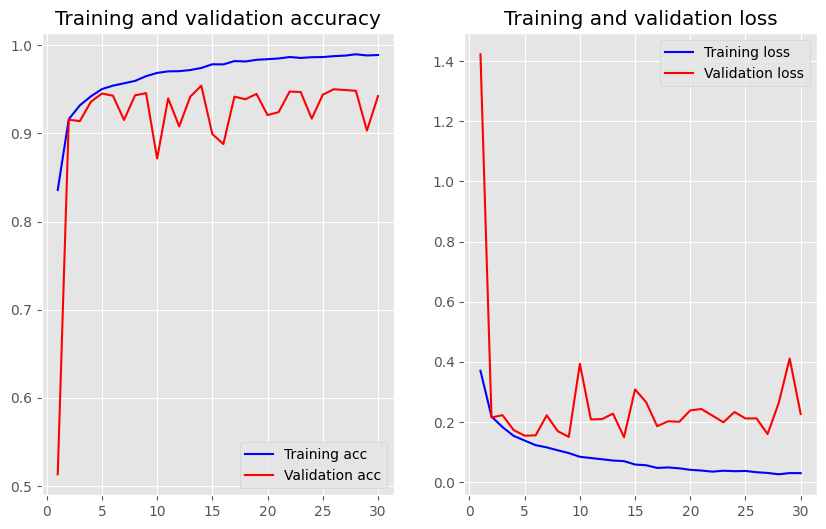

In [61]:
fig = plot_history(history_best)

In [62]:
y_pred = CNNmodel_best.predict(X_testT)
y_pred = np.rint(y_pred)

y_pred = np.argmax(y_pred,axis = 1)

acc = metrics.accuracy_score(test_y, y_pred)
print("accuracy: ",acc)
conf = metrics.confusion_matrix(test_y, y_pred)
print("conf matrix: \n", conf)
#overfit

235/235 [==============================] - 1s 3ms/step
accuracy:  0.5268
conf matrix: 
 [[3715   76]
 [3473  236]]


In [66]:
CNNmodel_underfit = keras.Sequential([
                  layers.Conv2D(4, (3, 3), input_shape=(50, 50, 1), activation='relu'),
                  BatchNormalization(),
                  layers.MaxPooling2D((2,2)),
                  layers.Dropout(0.1),

                  layers.Flatten(),
                  layers.Dense(2, activation='relu'),
                  layers.Dropout(0.2),
                  layers.Dense(2, activation = 'sigmoid')])

opt = tf.optimizers.Adam(learning_rate=0.000001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

CNNmodel_underfit.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
CNNmodel_underfit.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

history_underfit = CNNmodel_underfit.fit(train_X, train_y, epochs = 30, validation_split=0.2, batch_size=64)

h_eval_dict = CNNmodel_underfit.evaluate(X_testT,Y_testT, return_dict=True)
CNNmodel_underfit.save('bestmodel_for_underfit')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 4)         40        
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 4)        16        
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 4)        0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 24, 24, 4)         0         
                                                                 
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 dense_18 (Dense)            (None, 2)                

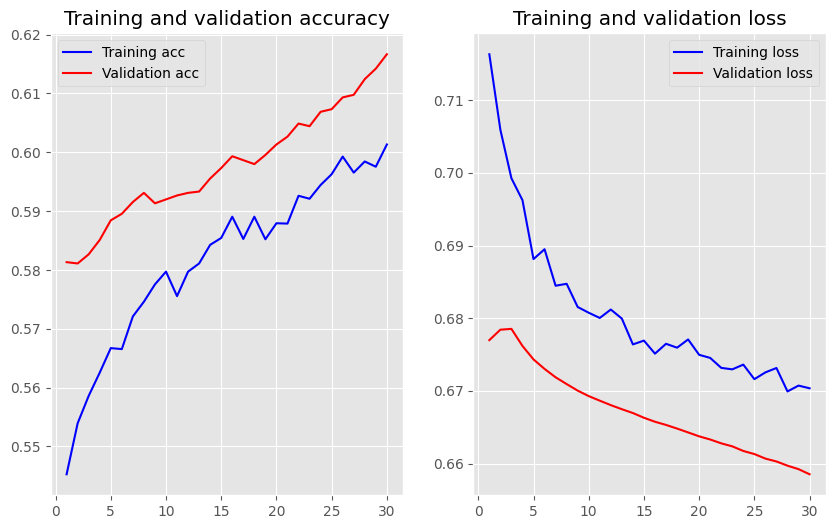

In [67]:
fig = plot_history(history_underfit)

In [68]:
y_pred = CNNmodel_underfit.predict(X_testT)
y_pred = np.rint(y_pred)

y_pred = np.argmax(y_pred,axis = 1)

acc = metrics.accuracy_score(test_y, y_pred)
print("accuracy: ",acc)
conf = metrics.confusion_matrix(test_y, y_pred)
print("conf matrix: \n", conf)
#underfit

235/235 [==============================] - 1s 2ms/step
accuracy:  0.6005333333333334
conf matrix: 
 [[3332  459]
 [2537 1172]]


In [ ]:
#model = keras.models.load_model('cnn_model')